In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import io
import os
import statistics
from math import pi
import pickle

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay, euclidean_distances
from sklearn.svm import LinearSVC

from sklearn.naive_bayes import GaussianNB

In [2]:
import warnings
warnings.filterwarnings('ignore')

Загружаем датасет с диска

In [3]:
from google.colab import files
uploaded = files.upload()

Saving water_potability.csv to water_potability (2).csv


In [4]:
df = pd.read_csv(io.StringIO(uploaded['water_potability.csv'].decode('utf-8')))
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Text(0.5, 1.0, 'Count of Potability')

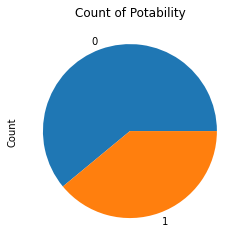

In [7]:
data = df.value_counts('Potability')
data.plot(kind='pie')
plt.ylabel('Count')
plt.title('Count of Potability')

Чистим нулевые элементы

In [8]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_clean = imp_mean.fit_transform(df)

In [9]:
df_clean = pd.DataFrame(df_clean,columns=df.columns)
df_clean.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [10]:
df_clean.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0.0
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0.0
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0.0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0.0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0.0


In [11]:
X =  normalize(df_clean.drop("Potability", axis = 1).to_numpy(), norm = "max", axis = 0)
y = df_clean["Potability"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1, shuffle = True)

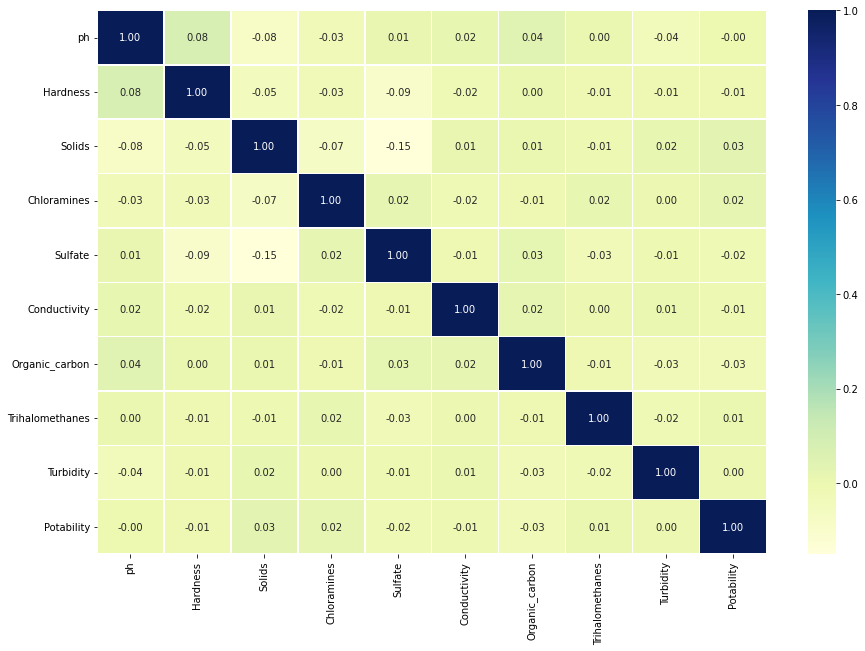

In [12]:
corr_mat = df_clean.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_mat,annot=True,linewidths=0.5,fmt='.2f',cmap='YlGnBu')

---

Печать результатов

In [13]:
def display_scores(model, X, y_true):
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    figure = plt.figure(figsize = (20, 5))
    matr = confusion_matrix(y_true, y_pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matr).plot(ax = ax)
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true = y_true, y_pred = y_pred, ax = ax)
    plt.show()

---

In [14]:
class Layer:
    def forward(self, *args):
        pass

    def backward(self, *args):
        pass
        
class CrossEntropyLoss(Layer):
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()

    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

class Net:
    def __init__(self, loss=CrossEntropyLoss()):
        self.layers = []
        self.loss_ = loss

    def add(self, l: Layer):
        self.layers.append(l)

    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x

    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z

    def update(self, lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.loss_.forward(p, y)
        pred = np.argmax(p, axis=1)
        acc = (pred == y).mean()
        return l, acc

    def train_epoch(self, train_x, train_labels, batch_size=4, lr=0.1):
        for i in range(0, len(train_x), batch_size):
            xb = train_x[i:i + batch_size]
            yb = train_labels[i:i + batch_size]

            p = self.forward(xb)
            l = self.loss_.forward(p=p, y=yb)
            dp = self.loss_.backward(loss=l)
            dx = self.backward(z=dp)
            self.update(lr)


Дополнительный класс линейной модели

In [15]:
class SoftMarginSVM:
    def __init__(self, n, alpha):
        self.alpha = alpha
        mu = 0.0
        sigma = 1.0 / np.sqrt(n)
        self.W = np.random.normal(mu, sigma, (1, n + 1))
    
    def forward(self, x):
        z = np.dot(x, self.W.T)
        return z
    
    def add_ones(self, x):
        ones = np.ones((x.shape[0], 1))
        return np.hstack((x, ones))
    
    def predict(self, x):
        res = self.forward(self.add_ones(x))
        return np.where(res < 0, 0, 1)
    
    def train_epoch(self, x, y, batch_size = 100, step = 1e-7):
        x = self.add_ones(x)
        y = np.where(y > 0, 1, -1)
        for i in range(0, len(x), batch_size):
            xb = x[i:i + batch_size]
            yb = y[i:i + batch_size]

            pred = self.forward(xb)
            grad = self.alpha * self.W
            for i in range(len(xb)):
                if (yb[i] * pred[i] < 1):
                    grad -= yb[i] * xb[i]
            self.W -= step * grad

---

**Linear Regression**

In [32]:
class MY_Linear(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, itern, bs):
        self.lr = lr
        self.itern = itern
        self.bs = bs
        pass
    
    def sigmoid(self, x):
        self.l = 1 / (1 + np.exp(- x))
        return self.l
        
    def fit(self, data, labels):
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis = 1)
        self.W = np.random.normal(0, 1, (len(data[0]),))
        
        for i in range(self.itern):
            for i in range(0, len(data), self.bs):
                xb = data[i:i + self.bs]
                yb = labels[i:i + self.bs]
                p = np.dot(self.W, xb.T)
                s = self.sigmoid(p)
                dp = np.dot(xb.T, (s - yb).T)
                self.W -= self.lr * dp
        
    def predict(self, maindata):
        maindata = np.concatenate((maindata, np.ones((maindata.shape[0],1))), axis = 1)
        p = np.dot(self.W, maindata.T)
        s = self.sigmoid(p)
        return (s > 0.5).astype('int64')

In [35]:
lin_grid = GridSearchCV(Pipeline([("lin", MY_Linear(0.1, 10, 5))]),
                    {"lin__itern" : [1, 5, 10, 20],
                     "lin__bs" : [1, 5, 10, 15],
                     "lin__lr" : [0.1, 0.01, 0.001]})
lin_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('lin',
                                        MY_Linear(bs=5, itern=10, lr=0.1))]),
             param_grid={'lin__bs': [1, 5, 10, 15],
                         'lin__itern': [1, 5, 10, 20],
                         'lin__lr': [0.1, 0.01, 0.001]})

Accuracy: 0.5670731707317073
Recall: 0.0
Precision: 0.0


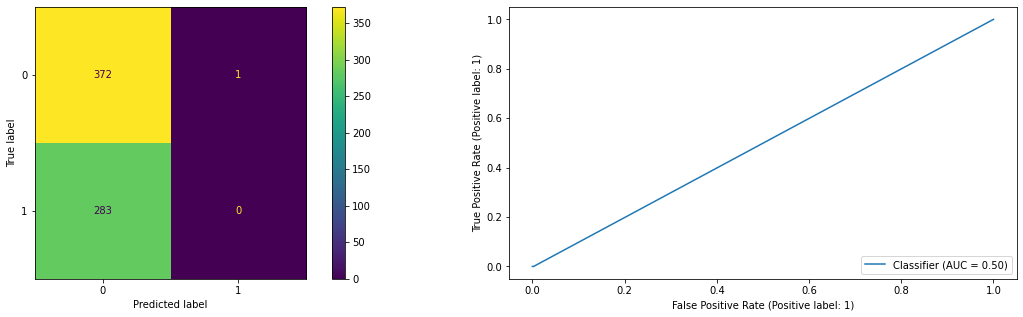

In [58]:
lin_estimator = lin_grid.best_estimator_
display_scores(lin_estimator, X_test, y_test)

In [60]:
with open('linear.pickle', 'wb') as f:
   pickle.dump(lin_estimator, f, pickle.HIGHEST_PROTOCOL)
files.download('linear.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
lin_random_grid =  RandomizedSearchCV(Pipeline([("lin", MY_Linear(0.1, 10, 5))]),
                    {"lin__itern" : [1, 5, 10, 20],
                     "lin__bs" : [1, 5, 10, 15],
                     "lin__lr" : [0.1, 0.01, 0.001]})
lin_random_grid.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('lin',
                                              MY_Linear(bs=5, itern=10,
                                                        lr=0.1))]),
                   param_distributions={'lin__bs': [1, 5, 10, 15],
                                        'lin__itern': [1, 5, 10, 20],
                                        'lin__lr': [0.1, 0.01, 0.001]})

Accuracy: 0.5685975609756098
Recall: 0.014134275618374558
Precision: 0.5


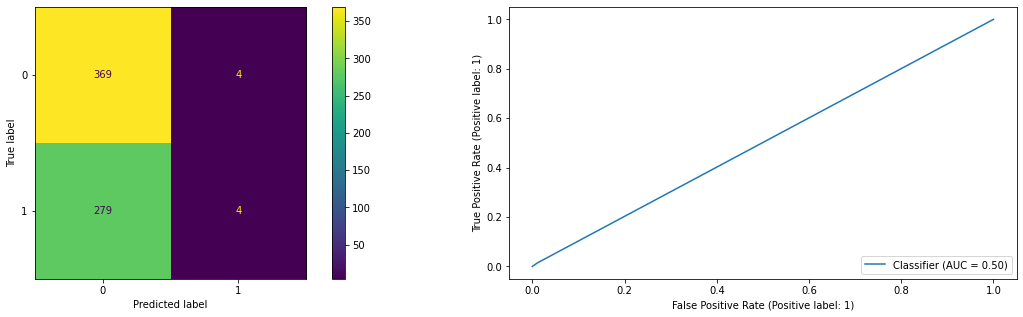

In [39]:
lin_random_best = lin_random_grid.best_estimator_
display_scores(lin_random_best, X_test, y_test)

---

**KNN**

In [22]:
class MY_KNN(ClassifierMixin, BaseEstimator):
    def __init__(self, k = 1):
        self.k = k

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        check_is_fitted(self, ["X_", "y_"])
        
        # Input validation
        X = check_array(X)
        
        y = np.ndarray((X.shape[0],))
        for (i, elem) in enumerate(X):
            distances = euclidean_distances([elem], self.X_)[0]
            neighbors = np.argpartition(distances, kth = self. k - 1)
            k_neighbors = neighbors[:self.k]
            labels, cnts = np.unique(self.y_[k_neighbors], return_counts = True)
            y[i] = labels[cnts.argmax()]
        return y

In [23]:
knn_model = GridSearchCV(Pipeline([("KNN", MY_KNN())]), {"KNN__k" : [1, 3, 5, 7, 9]})
knn_model.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('KNN', MY_KNN())]),
             param_grid={'KNN__k': [1, 3, 5, 7, 9]})

Accuracy: 0.6280487804878049
Recall: 0.35335689045936397
Precision: 0.6211180124223602


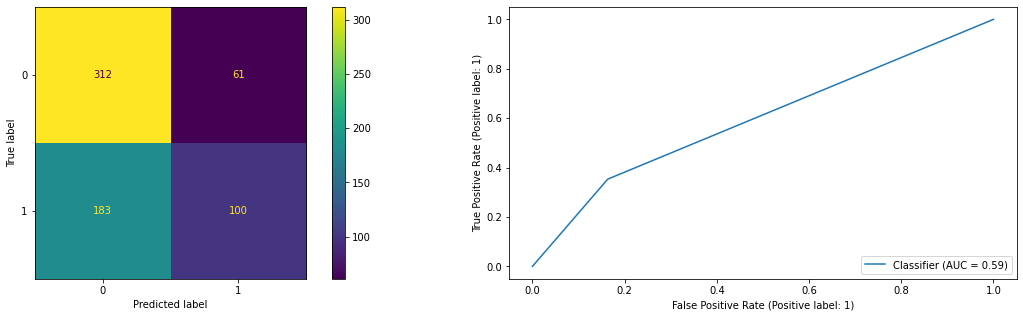

In [24]:
knn_estimator = knn_model.best_estimator_
display_scores(knn_estimator, X_test, y_test)

In [61]:
with open('knn.pickle', 'wb') as f:
     pickle.dump(knn_estimator, f, pickle.HIGHEST_PROTOCOL)
files.download('knn.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn_grid = GridSearchCV(Pipeline([('knn', KNeighborsClassifier())]), {'knn__n_neighbors' : [1, 3, 5, 7, 9]})
knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 3, 5, 7, 9]})

Accuracy: 0.6280487804878049
Recall: 0.35335689045936397
Precision: 0.6211180124223602


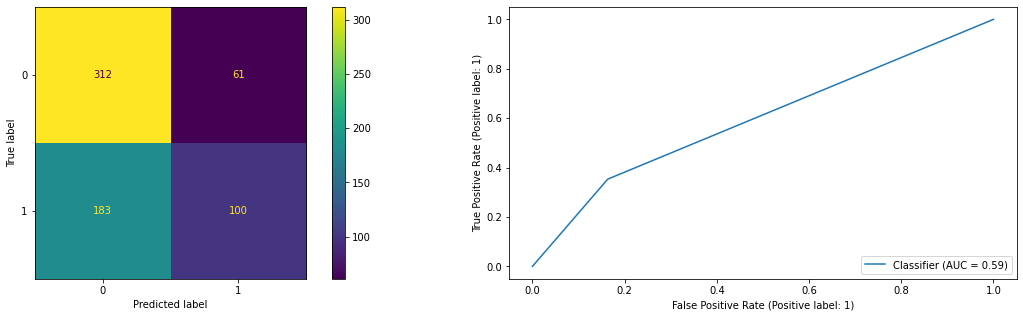

In [49]:
knn_estimator = knn_grid.best_estimator_
display_scores(knn_estimator, X_test, y_test)

---

**Naive Bayes**

In [29]:
class MY_Naive_Bayes(ClassifierMixin, BaseEstimator):
    def __init__(self):
        None

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        
        self.X_ = X
        self.y_ = y
        
        labels, cnts = np.unique(self.y_, return_counts = True)
        self.labels = labels
        self.p_of_y = np.array([elem / self.y_.shape[0] for elem in cnts])
        self.means = np.array([self.X_[self.y_ == elem].mean(axis = 0) for elem in labels])
        self.stds = np.array([self.X_[self.y_ == elem].std(axis = 0) for elem in labels])
        # Return the classifier
        return self

    def gaussian(self, mu, sigma, x0):
        return np.exp(-(x0 - mu) ** 2 / (2 * sigma)) / np.sqrt(2.0 * pi * sigma)
    
    def predict(self, X):
        check_is_fitted(self, ['X_', 'y_'])
        
        X = check_array(X)
        
        res = np.zeros(X.shape[0])
        for (i, elem) in enumerate(X):
            p = np.array(self.p_of_y)
            for (j, label) in enumerate(self.labels):
                p_x_cond_y = np.array([self.gaussian(self.means[j][k], self.stds[j][k], elem[k]) for k in range(X.shape[1])])
                p[j] *= np.prod(p_x_cond_y)
            res[i] = np.argmax(p)
        return res

Accuracy: 0.5685975609756098
Recall: 0.0
Precision: 0.0


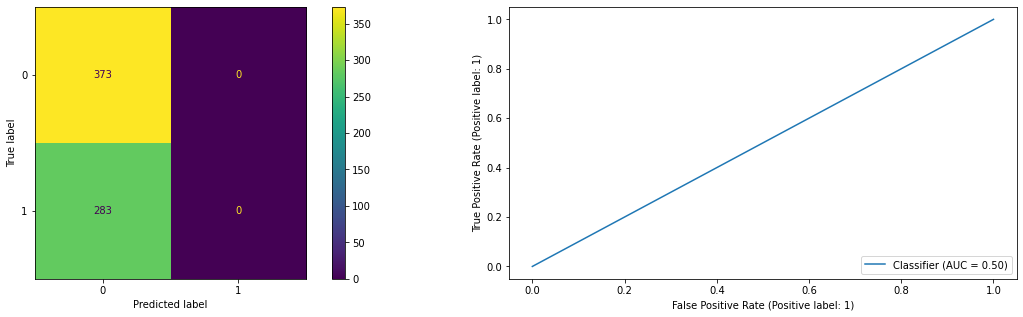

In [53]:
bayes_pipe = Pipeline([("NB", MY_Naive_Bayes())])
bayes_pipe.fit(X_train, y_train)
display_scores(bayes_pipe, X_test, y_test)

In [62]:
with open('Bayes.pickle', 'wb') as f:
     pickle.dump(bayes_pipe, f, pickle.HIGHEST_PROTOCOL)
files.download('Bayes.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Библиотечный вариант

Accuracy: 0.600609756097561
Recall: 0.21554770318021202
Precision: 0.6039603960396039


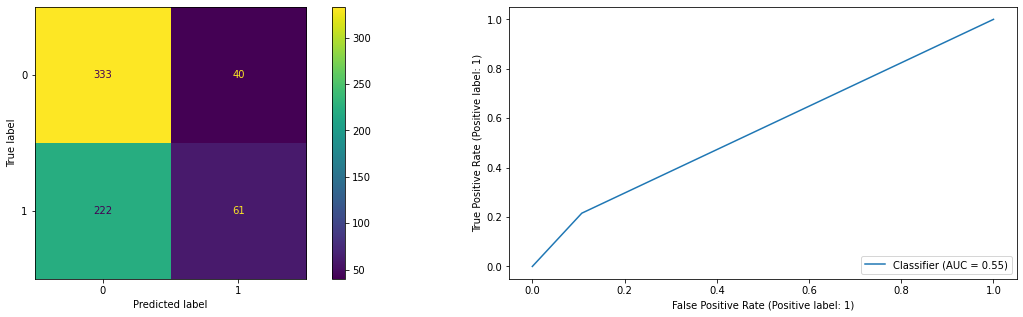

In [37]:
bayes_pipe = Pipeline([("NB", GaussianNB())])
bayes_pipe.fit(X_train, y_train)
display_scores(bayes_pipe, X_test, y_test)

---

**SVM**

In [40]:
class MY_SVM(ClassifierMixin, BaseEstimator):
    def __init__(self, epoches=1, batch_size=10, SGD_step=0.001, alpha=0.1, nin=10):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
        self.nin = nin
        self.alpha = alpha
        self.Net = SoftMarginSVM(nin, alpha)

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.is_fitted_ = True
        for _ in range(self.epoches):
            self.Net.train_epoch(X, y, self.batch_size, self.SGD_step)
        # Return the classifier
        return self

    def predict(self, X):
        y = self.Net.predict(X)
        return y

    def getW(self):
        return self.Net.W

In [43]:
svm_grid = GridSearchCV(Pipeline([("SVM", MY_SVM(nin=X_train.shape[1]))]),
                    {"SVM__epoches" : [1, 2, 3, 5, 10, 15],
                     "SVM__batch_size" : [1, 5, 10, 15, 20],
                     "SVM__SGD_step" : [0.1, 0.01, 0.001],
                     "SVM__alpha" : [0, 0.00001, 0.001, 0.1]})
svm_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('SVM', MY_SVM(nin=9))]),
             param_grid={'SVM__SGD_step': [0.1, 0.01, 0.001],
                         'SVM__alpha': [0, 1e-05, 0.001, 0.1],
                         'SVM__batch_size': [1, 5, 10, 15, 20],
                         'SVM__epoches': [1, 2, 3, 5, 10, 15]})

Accuracy: 0.5670731707317073
Recall: 0.02120141342756184
Precision: 0.46153846153846156


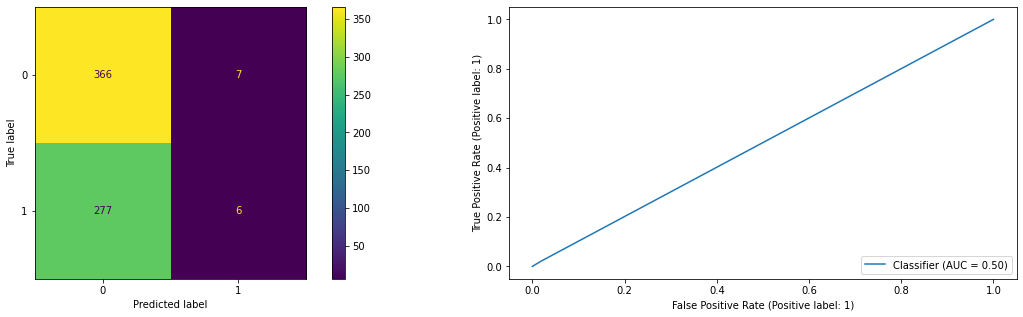

In [44]:
svm_estimator = svm_grid.best_estimator_
display_scores(svm_estimator, X_test, y_test)

In [63]:
with open('svm.pickle', 'wb') as f:
     pickle.dump(svm_estimator, f, pickle.HIGHEST_PROTOCOL)
files.download('svm.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
svm_pipe = GridSearchCV(Pipeline([("svc", LinearSVC())]),
                    {"svc__loss" : ["hinge", "squared_hinge"],
                     "svc__max_iter" : [100000, 1000, 1000000, 50000]})
svm_pipe.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('svc', LinearSVC())]),
             param_grid={'svc__loss': ['hinge', 'squared_hinge'],
                         'svc__max_iter': [100000, 1000, 1000000, 50000]})

Accuracy: 0.5685975609756098
Recall: 0.0
Precision: 0.0


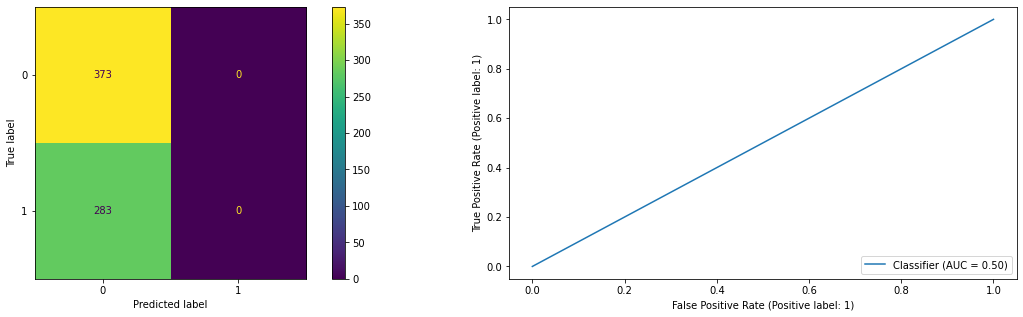

In [48]:
svm_estimator = svm_pipe.best_estimator_
display_scores(svm_estimator, X_test, y_test)